#Read Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
df=pd.read_csv("/content/drive/My Drive/BERT/group_all_labelled.csv")
# display(df)

In [ ]:
#unbalanced data set, taking half size of False as training data
df_1=df[df["Near Miss Event"]==False].sample(frac=0.5)
df_0=df[df["Near Miss Event"]==True]
df=pd.concat([df_0,df_1],axis=0)

# Randomized data and split train/val data set

In [ ]:
#Read data and randomized data
df=df.sample(frac=1)
import pandas as pd
df["category"]=df["Near Miss Event"]
df["text"]=df["event_text"]
df_val=df[:100]
df=df[100:]

In [ ]:
#install correct version 
# ! pip install tensorflow==1.13.1
# ! pip install keras==2.2.4
# ! pip install keras_bert==0.82.0

In [ ]:
#Check the correct version of the packages
import keras #2.2.4
print (keras.__version__)

import tensorflow #1.13.1
print (tensorflow.__version__)

import keras_bert #0.82.0
print (keras_bert.__version__)

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarn

2.2.4
1.13.1
0.82.0


# Import Bert Model

In [ ]:
#Import BERT Model
import json
import numpy as np
from keras.utils import to_categorical
from random import choice
from tqdm import tqdm
from keras_bert import load_trained_model_from_checkpoint, Tokenizer
from keras.layers import Dense, Activation, Multiply, Add, Lambda
import re, os
import codecs
import keras
import keras.backend as K

from keras.callbacks import *
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "4"
mode = 0
maxlen =510 #Max length of text
learning_rate = 5e-5
min_learning_rate = 1e-5
config_path = '/content/drive/My Drive/BERT/cased_L-12_H-768_A-12/bert_config.json'
checkpoint_path = '/content/drive/My Drive/BERT/cased_L-12_H-768_A-12/bert_model.ckpt'
dict_path = '/content/drive/My Drive/BERT/cased_L-12_H-768_A-12/vocab.txt'

token_dict = {}

with codecs.open(dict_path, 'r', 'utf8') as reader:
    for line in reader:
        token = line.strip()
        token_dict[token] = len(token_dict)

class OurTokenizer(Tokenizer):
    def _tokenize(self, text):
        R = []
        for c in text:
            if c in self._token_dict:
                R.append(c)
            elif self._is_space(c):
                R.append('[unused1]') 
            else:
                R.append('[UNK]') 
        return R

tokenizer = OurTokenizer(token_dict)

import pandas as pd 
d_category_to_number=dict(zip(df["category"].unique(),list(range(len(df["category"].unique())))))   #category == number
df["category"]=df["category"].map(d_category_to_number)
df_val["category"]=df_val["category"].map(d_category_to_number) #
num_classes = len(df["category"].unique())  #predict how many categories

# Model training

In [ ]:
#Data generator and model part
#import tensorflow.compat.v1 as tf
from keras.layers import *
from keras.models import Model
import keras.backend as K
from keras.callbacks import Callback
from keras.optimizers import Adam
#0 padding method: makes sure all the texts have same length
def seq_padding(X, padding=0):
    L = [len(x) for x in X]
    ML = max(L)
    return np.array([
        np.concatenate([x, [padding] * (ML - len(x))]) if len(x) < ML else x for x in X
    ])


df=df.sample(frac=1)
label=list(df["category"])
DATA_LIST = []
for t,l in zip(df["text"],label):
    DATA_LIST.append((t, to_categorical(l, num_classes )))
DATA_LIST_val=[]
for t,l in zip(df_val["text"],list(df_val["category"])):
    DATA_LIST_val.append((t, to_categorical(l, num_classes )))

class data_generator:
    def __init__(self, data, batch_size=4, shuffle=True):
        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.steps = len(self.data) // self.batch_size
        if len(self.data) % self.batch_size != 0:
            self.steps += 1
 
    def __len__(self):
        return self.steps
 
    def __iter__(self):
        
        while True:
            idxs = list(range(len(self.data)))
            
            if self.shuffle:
                np.random.shuffle(idxs)
 
            X1, X2, Y = [], [], []
            for i in idxs:
                d = self.data[i]
                text = d[0][:maxlen]
                x1, x2 = tokenizer.encode(first=text)
                y = d[1]
                X1.append(x1)
                X2.append(x2)
                Y.append([y])
                if len(X1) == self.batch_size or i == idxs[-1]:
                    X1 = seq_padding(X1)
                    X2 = seq_padding(X2)
                    Y = seq_padding(Y)
                    
                    yield [X1, X2], Y[:, 0, :]
                    [X1, X2, Y] = [], [], []

def build_bert(nclass):
    bert_model = load_trained_model_from_checkpoint(config_path, checkpoint_path, seq_len=None)  #Load Pre-trained data
 
    for l in bert_model.layers:
        l.trainable = True
 
    x1_in = Input(shape=(None,))
    x2_in = Input(shape=(None,))
 
    x = bert_model([x1_in, x2_in])
    x = Lambda(lambda x: x[:, 0])(x) # 
    p = Dense(num_classes, activation='softmax')(x)
 
    model = Model([x1_in, x2_in], p)
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(1e-5),    #lr small enough
                  metrics=['accuracy'])
    print(model.summary())
    return model

model = build_bert(num_classes)
early_stopping = EarlyStopping(monitor='val_acc', patience=3)   #EarlyStopping, avoid overfitting
plateau = ReduceLROnPlateau(monitor="val_acc", verbose=1, mode='max', factor=0.5, patience=2) #Stop when val_acc stop increasing
checkpoint = ModelCheckpoint('58bert_long_all_new.hdf5', monitor='val_acc',verbose=2, save_best_only=True, mode='max', save_weights_only=True) #Saving best model

train_D = data_generator(DATA_LIST, shuffle=True)
valid_D = data_generator(DATA_LIST_val, shuffle=True)

#Model Training
# model.fit_generator(
#     train_D.__iter__(),
#     steps_per_epoch=len(train_D),
#     epochs=5,
#     validation_data=valid_D.__iter__(),
#     validation_steps=len(valid_D),
#     callbacks=[early_stopping, plateau, checkpoint],
# )

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
model_2 (Model)                 (None, None, 768)    107719680   input_1[0][0]                    
                                                                 input_2[0][0]                    
_____________________

In [ ]:
# retraining the model! takes a very long time!!
#model.fit_generator(
 #   train_D.__iter__(),
  #  steps_per_epoch=len(train_D),
   # epochs=50,
    #validation_data=valid_D.__iter__(),
    #validation_steps=len(valid_D),
    #callbacks=[early_stopping, plateau, checkpoint],
#)

#Load best model

In [ ]:
#load best weitghts
model.load_weights("/content/drive/My Drive/BERT/58bert_long_all_new.hdf5")

#  Testing result on test set

In [ ]:
#Calculating AUC and ROC etc
def show_result(DATA_LIST_val):
#     valid_D = data_generator(DATA_LIST_val, shuffle=True)
    ypre=[]
    ytrue=[]
    yauc=[]
    for i in range(len(DATA_LIST_val)):
         x1, x2 = tokenizer.encode(first=DATA_LIST_val[i][0][:maxlen])
#          tmp=next(valid_D.__iter__())
         tmp_pre=list(np.argmax(model.predict([[x1],[x2]]),axis=1))
         # print (model.predict([[x1],[x2]])) #print the possibility to be a 'True' of 'False'
         if list(model.predict([[x1],[x2]]))[0][1]>0.2:
            tmp_pre=[1]
         else:
            tmp_pre=[0]
         tmp_ytrue=[np.argmax(DATA_LIST_val[i][1],axis=0)]
         yauc+=list(model.predict([[x1],[x2]])[:,1])
         ypre+=tmp_pre
         ytrue+=tmp_ytrue
    from sklearn import metrics
    from sklearn import metrics
    fpr_lr,tpr_lr,threshold_lr = metrics.roc_curve(ytrue,yauc)    
    auc_lr = metrics.auc(fpr_lr,tpr_lr)
    print ("auc:",auc_lr)
    def leibie_acc(test_pre,y_test):
        test_pre=np.array(test_pre)
        y_test=np.array(y_test)
        label2=dict(zip(d_category_to_number.values(), d_category_to_number.keys()))

        print ("Accuracy:",sum((test_pre==y_test).astype(int))/len(y_test))
        for i in set(list(y_test)):

            tmp=(test_pre[np.where(y_test==i)]==y_test[np.where(y_test==i)]).astype(int)
            acc=sum(tmp)/len(tmp)
            print (label2[i],"Label accuracy:",acc,"value is",len(tmp))
        return 


    import seaborn as sns
    from sklearn.metrics import confusion_matrix
    import matplotlib.pyplot as plt

    def conf_matr(valp,valy):
        sns.set()
        np.set_printoptions(suppress=True)
        f,ax=plt.subplots()
        valp=np.array(valp)
        valy=np.array(valy)
        C2= confusion_matrix(valy , valp, labels=list(range(2)))
        print(C2) #Print
        sns.heatmap(C2,annot=True,ax=ax,fmt='.20g') #draw heat map

        ax.set_title('confusion matrix') #Title
        ax.set_xlabel('predict') #x-axis
        ax.set_ylabel('true') #y-axis
        plt.show()
    def eval_index(val_data,val_y):
    #     valpre=model_load.predict(val_data)
        leibie_acc(val_data,val_y)
        conf_matr(val_data,val_y)
    def roc(X_val,Y_val):
        prelabel=X_val
        from sklearn.metrics import roc_curve, auc


        color = 'cyan'



        fpr, tpr, thresholds = metrics.roc_curve(ytrue,yauc)

        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, color=color,
                 label='ROC')

        plt.xlim([-0.05, 1.05])
        plt.ylim([-0.05, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('roc')
#         plt.legend(loc="lower right")
        plt.show()
    from sklearn.metrics import classification_report
    roc(yauc,ytrue)
    print(classification_report(ytrue,ypre))
    eval_index(ypre,ytrue)


auc: 0.863030303030303


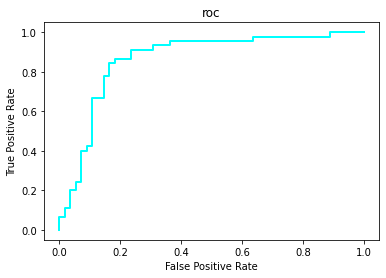

              precision    recall  f1-score   support

           0       0.95      0.64      0.76        55
           1       0.68      0.96      0.80        45

    accuracy                           0.78       100
   macro avg       0.81      0.80      0.78       100
weighted avg       0.83      0.78      0.78       100

Accuracy: 0.78
False Label accuracy: 0.6363636363636364 value is 55
True Label accuracy: 0.9555555555555556 value is 45
[[35 20]
 [ 2 43]]


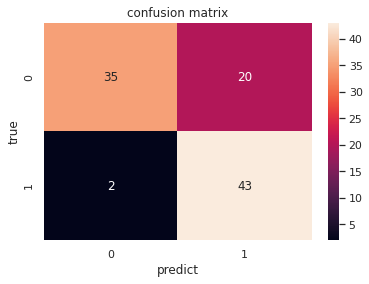

In [ ]:
show_result(DATA_LIST_val)

In [ ]:
label2=dict(zip(d_category_to_number.values(), d_category_to_number.keys()))
def ceshi(text):   
    if len(text.split(" "))>512:
        print (text)
        text=" ".join(text.split(" ")[:510])
    x1, x2 = tokenizer.encode(first=text.lower())
#     print (len(x1))
    if list(model.predict([[x1[:512]],[x2[:512]]]))[0][1]>0.5:
            tmp_pre=1
    else:
            tmp_pre=0
#     print (tmp_pre)
    return label2[tmp_pre]
ceshi("I am a student not sd sa") #testing a random sentence

False

In [ ]:
ceshi("Box 1123 West Perth 6872 Telephone +61 94236100 Facsimile +61 94236270 www.newmont.com COMBINED ANNUAL REPORT ON EXPLORATION FOR THE PERIOD 01/01/2005 TO 31/12/2005 PROJECT C146/2005 PINJIN VOLUME 1 OF 1 Author: J Rotherham and G Kubale Date: 21st February 2006 Authorised by: Wade Johnson Distribution: Newmont Exploration Library Adelaide WA Department of Industry and Resources Reference: C146-2005 A05.PDF The contents of this report remain the property of Newmont Exploration Pty Limited and may not be published in whole or in part nor used in a company prospectus without the written consent of the company.")

False

# Testing model

In [ ]:

test_data = pd.read_csv("/content/drive/My Drive/BERT/group_test_events.csv")
test_event_text = test_data.event_text.to_list()
result = []
for sent in test_event_text:
  pred = (sent, ceshi(sent))
  #print(pred)
  result.append(pred)

In [ ]:
#check text lengths
text_lengths = []
for sent in test_event_text:
  text_lengths.append(len(sent.split(' ')))
print(max(text_lengths))


206


In [ ]:
test_label = test_data['event_label']
TEST_DATA_LIST = []
for t, l in zip(test_data['event_text'], test_label):
  TEST_DATA_LIST.append((t, to_categorical(l, num_classes )))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


auc: nan


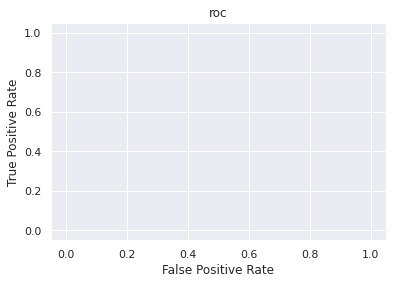

              precision    recall  f1-score   support

           0       1.00      0.50      0.67        46
           1       0.00      0.00      0.00         0

    accuracy                           0.50        46
   macro avg       0.50      0.25      0.33        46
weighted avg       1.00      0.50      0.67        46

Accuracy: 0.5
False Label accuracy: 0.5 value is 46
[[23 23]
 [ 0  0]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


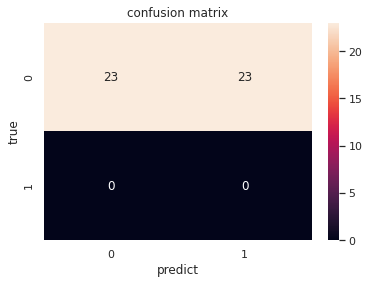

In [ ]:
show_result(TEST_DATA_LIST)